In [1]:
import geopandas as gpd 
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import datetime as dt 
from shapely.geometry import Point, Polygon
import sys
import glob 
import os 
from scipy import stats 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import seaborn as sns
import copy

files_path = "C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/2015_04_to_2015_05"
read_files = glob.glob(os.path.join(files_path,"*.csv"))

li = []

for file in read_files: 
    df = pd.read_csv(file, index_col = None, header = 0)
    li.append(df)


files_path_census = "C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/Census_data/Census_data_combined_boroughs"
read_files_census = glob.glob(os.path.join(files_path_census,"*.csv"))

li = []

for file in read_files_census: 
    df_census = pd.read_csv(file, index_col = None, header = 0)
    new_header = df_census.iloc[0]
    df_census = df_census[1:]
    df_census.columns = new_header
    df_census.reset_index(inplace=True, drop=True)
    li.append(df_census)

df_census = pd.concat(li, axis = 0, ignore_index = True)
df_census = df_census.drop(df_census.index[[26, 65]])
df_census = df_census.drop(df_census[df_census['Total!!Estimate!!Total population'] == '0'].index)
df = df.drop(df[df['start station name'] == 'South St & Gouverneur Ln'].index)

#files_path_census = "C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/Census_data/Census_data_2018-2012_MANHATTAN/ACSST5Y2014.S0101_data_with_overlays_2020-02-02T201411.csv"
#df_census = pd.read_csv(files_path_census)

#new_header = df_census.iloc[0]
#df_census = df_census[1:]
#df_census.columns = new_header
#df_census.reset_index(inplace=True, drop=True)



C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [2]:
df_census.head()

,Female!!Estimate!!AGE!!10 to 14 years,Female!!Estimate!!AGE!!15 to 19 years,Female!!Estimate!!AGE!!20 to 24 years,Female!!Estimate!!AGE!!25 to 29 years,Female!!Estimate!!AGE!!30 to 34 years,Female!!Estimate!!AGE!!35 to 39 years,Female!!Estimate!!AGE!!40 to 44 years,Female!!Estimate!!AGE!!45 to 49 years,Female!!Estimate!!AGE!!5 to 9 years,Female!!Estimate!!AGE!!50 to 54 years,...,Total!!Margin of Error!!SELECTED AGE CATEGORIES!!62 years and over,Total!!Margin of Error!!SELECTED AGE CATEGORIES!!65 years and over,Total!!Margin of Error!!SELECTED AGE CATEGORIES!!75 years and over,Total!!Margin of Error!!SUMMARY INDICATORS!!Age dependency ratio,Total!!Margin of Error!!SUMMARY INDICATORS!!Child dependency ratio,Total!!Margin of Error!!SUMMARY INDICATORS!!Median age (years),Total!!Margin of Error!!SUMMARY INDICATORS!!Old-age dependency ratio,Total!!Margin of Error!!SUMMARY INDICATORS!!Sex ratio (males per 100 females),Total!!Margin of Error!!Total population,id
0,6.3,7.2,8.3,7.8,6.8,6.9,6.2,6.0,6.8,6.7,...,1.1,1.0,0.8,4.4,3.8,1.0,1.8,5.0,2214,8600000US10451
1,7.5,8.5,8.2,6.7,8.2,7.0,7.1,7.6,7.9,5.9,...,0.6,0.5,0.4,3.1,2.9,0.7,0.9,4.3,1863,8600000US10452
2,7.1,7.1,8.8,8.5,8.2,5.8,6.3,7.4,7.1,7.3,...,0.6,0.5,0.3,2.7,2.6,1.0,0.9,4.6,2074,8600000US10453
3,8.5,9.3,7.5,7.5,6.9,7.8,6.0,7.3,8.3,5.1,...,1.1,1.0,0.6,5.3,4.4,1.0,1.9,6.6,1351,8600000US10454
4,6.0,6.6,8.0,8.6,7.8,6.7,6.7,6.4,8.4,6.2,...,1.0,0.8,0.5,4.7,4.2,1.2,1.6,6.9,1663,8600000US10455


In [3]:
df_census.shape

(172, 218)

In [4]:
df["starttime"] = pd.to_datetime(df["starttime"], infer_datetime_format = True)
df["stoptime"] = pd.to_datetime(df["stoptime"], infer_datetime_format = True)
df["trip duration minutes"] = df["tripduration"]/60

df["user type number"] = 1
df.loc[df["usertype"] != "Subscriber", "user type number"] = 0

In [5]:
def get_distance(start_lat, start_long, end_lat, end_long): 
    radius = 6371 
    avg_lat = (start_lat + end_lat)/2 * (np.pi/180)
    delta_lat = (end_lat - start_lat) * (np.pi/180)
    delta_long = (end_long - start_long) * (np.pi/180)
    
    distance = radius*np.sqrt(delta_lat**2 + (np.cos(avg_lat)*delta_long)**2)
    return distance

df["age"] = 2015 - df["birth year"]

df["round trip"] = "yes"
df.loc[df["start station name"] != df["end station name"], "round trip"] = "no" 

df["distance traveled"] = get_distance(df["start station latitude"], 
                                       df["start station longitude"], 
                                       df["end station latitude"], 
                                       df["end station longitude"])


In [6]:
df["age"] = 2015 - df["birth year"]

In [7]:
start_stations = df.groupby(df["start station name"])

In [7]:
indiv_station_dict = dict()
for start_station, frame in start_stations: 
    indiv_station_dict[start_station] = pd.DataFrame(frame['age']).dropna()

In [8]:
indiv_station_dict['1 Ave & E 15 St']

,age
131,29.0
214,24.0
219,57.0
305,31.0
316,21.0
...,...
961771,20.0
961897,32.0
961907,27.0
961916,26.0


In [9]:
import altair as alt 
alt.data_transformers.enable('default', max_rows=None)
indiv_station_test = indiv_station_dict['1 Ave & E 15 St']
chart_test = alt.Chart(indiv_station_test).mark_bar().encode(
    alt.X('age', bin=alt.Bin(extent=[18,90], step=5)), 
    y='count()').properties(width=450, height=250, title='1 Ave & E 15 St')

chart_test

alt.Chart(...)

<font size = 5> The following will clean up the census dataframe<font>

In [8]:
df_census_filtered = df_census.filter(regex = '(Total!!Estimate!!AGE|Total!!Estimate!!Total|Geographic Area Name)')

In [9]:
df_census_filtered['Geographic Area Name'] = df_census_filtered['Geographic Area Name'].map(lambda x: x.lstrip('ZCTA5'))
df_census_filtered.rename(columns={'Geographic Area Name':'postalCode'}, inplace=True)

C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [10]:
#Be careful, in some csv files, the "Total!!Estimate!!Age!!" is in percent of population, and in other files 
#it can be actual number of people. Make sure to take a look at the csv file before hand. 
df_census_filtered

,postalCode,Total!!Estimate!!AGE!!10 to 14 years,Total!!Estimate!!AGE!!15 to 19 years,Total!!Estimate!!AGE!!20 to 24 years,Total!!Estimate!!AGE!!25 to 29 years,Total!!Estimate!!AGE!!30 to 34 years,Total!!Estimate!!AGE!!35 to 39 years,Total!!Estimate!!AGE!!40 to 44 years,Total!!Estimate!!AGE!!45 to 49 years,Total!!Estimate!!AGE!!5 to 9 years,Total!!Estimate!!AGE!!50 to 54 years,Total!!Estimate!!AGE!!55 to 59 years,Total!!Estimate!!AGE!!60 to 64 years,Total!!Estimate!!AGE!!65 to 69 years,Total!!Estimate!!AGE!!70 to 74 years,Total!!Estimate!!AGE!!75 to 79 years,Total!!Estimate!!AGE!!80 to 84 years,Total!!Estimate!!AGE!!85 years and over,Total!!Estimate!!AGE!!Under 5 years,Total!!Estimate!!Total population
0,10451,6.7,7.8,8.4,7.6,6.7,6.3,6.5,6.4,8.4,6.2,4.4,5.2,3.3,2.8,2.3,1.3,1.4,8.3,47818
1,10452,8.1,8.3,8.2,7.1,7.5,6.6,6.7,7.0,8.8,6.1,5.2,4.3,2.7,2.1,1.2,0.8,0.6,8.7,75252
2,10453,7.5,8.1,9.3,7.9,7.5,6.2,6.8,6.9,7.5,6.9,5.6,4.5,2.8,1.9,1.1,0.7,0.6,8.3,79002
3,10454,8.7,9.2,9.1,7.4,7.0,7.4,6.2,6.6,8.7,5.3,3.9,2.9,2.0,2.5,1.8,1.6,0.7,9.0,38751
4,10455,7.4,6.8,8.6,8.7,7.9,6.7,6.3,6.0,8.7,5.8,4.6,3.7,2.8,2.9,1.3,0.9,1.0,9.8,39951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,10017,0.4,1.1,7.0,18.1,13.6,8.1,7.0,4.8,1.7,7.4,5.9,4.2,6.0,4.4,3.1,1.7,1.7,3.8,16472
175,10018,1.4,2.3,11.4,26.3,17.4,10.9,5.5,5.1,1.1,4.4,4.2,2.7,2.0,0.4,0.8,0.1,0.0,4.0,9168
176,10280,4.1,2.2,3.8,7.7,14.6,12.6,8.0,6.1,5.1,8.9,6.0,4.8,3.1,2.2,1.2,1.2,0.0,8.5,9552
177,10282,2.3,1.2,1.7,6.6,15.8,14.7,11.8,5.8,7.4,5.4,0.8,1.3,1.6,0.3,0.3,0.8,2.0,20.1,5730


In [72]:
df_census_filtered.iloc[0]

0
postalCode                                  11001
Total!!Estimate!!Total population           27156
Total!!Estimate!!AGE!!Under 5 years           5.2
Total!!Estimate!!AGE!!5 to 9 years            6.7
Total!!Estimate!!AGE!!10 to 14 years          6.6
Total!!Estimate!!AGE!!15 to 19 years          5.8
Total!!Estimate!!AGE!!20 to 24 years          5.7
Total!!Estimate!!AGE!!25 to 29 years          6.6
Total!!Estimate!!AGE!!30 to 34 years          4.5
Total!!Estimate!!AGE!!35 to 39 years          6.9
Total!!Estimate!!AGE!!40 to 44 years          7.3
Total!!Estimate!!AGE!!45 to 49 years          8.0
Total!!Estimate!!AGE!!50 to 54 years          7.4
Total!!Estimate!!AGE!!55 to 59 years          8.2
Total!!Estimate!!AGE!!60 to 64 years          6.7
Total!!Estimate!!AGE!!65 to 69 years          4.6
Total!!Estimate!!AGE!!70 to 74 years          3.2
Total!!Estimate!!AGE!!75 to 79 years          2.0
Total!!Estimate!!AGE!!80 to 84 years          1.9
Total!!Estimate!!AGE!!85 years and over       2.

In [11]:
df_zipbound = gpd.read_file('C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/Boundaries_by_Zipcode/NYC_Zipcode_tabulation.json')

In [6]:
df_zipbound.head(100)

,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostalCode,Shape_Leng,Shape_Area,@id,geometry
0,1,11372,Jackson Heights,NY,Queens,36,081,0,20624.692317,2.016328e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.86942 40.74916, -73.89507 40.746..."
1,2,11004,Glen Oaks,NY,Queens,36,081,0,23002.816039,2.260653e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.71068 40.75004, -73.70869 40.748..."
2,3,11040,New Hyde Park,NY,Queens,36,081,0,15749.161511,6.269333e+06,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.70098 40.73890, -73.70309 40.744..."
3,4,11426,Bellerose,NY,Queens,36,081,0,35932.810639,4.941836e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.72270 40.75373, -73.72251 40.753..."
4,5,11365,Fresh Meadows,NY,Queens,36,081,0,38693.565676,6.938587e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.81089 40.72717, -73.81116 40.728..."
5,6,11373,Elmhurst,NY,Queens,36,081,0,33755.870988,4.265940e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.88722 40.72753, -73.88723 40.728..."
6,7,11001,Floral Park,NY,Queens,36,081,0,13594.924549,9.155180e+06,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.70098 40.73890, -73.69960 40.739..."
7,8,11375,Forest Hills,NY,Queens,36,081,0,36277.076839,5.558777e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.85625 40.73672, -73.85205 40.737..."
8,9,11427,Queens Village,NY,Queens,36,081,0,31231.968593,3.956834e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.74169 40.73682, -73.73568 40.738..."
9,10,11374,Rego Park,NY,Queens,36,081,0,26323.994393,2.520346e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.86451 40.73407, -73.85872 40.735..."


In [12]:
df['geometry'] = df[['start station longitude', 'start station latitude']].apply(Point, axis=1)

In [25]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,gender,trip duration minutes,user type number,age,round trip,distance traveled,geometry
0,415,2015-05-01 00:00:11,2015-05-01 00:07:06,477,W 41 St & 8 Ave,40.756405,-73.990026,442,W 27 St & 7 Ave,40.746647,...,17012,Subscriber,1981.0,1,6.916667,1,34.0,no,1.133461,POINT (-73.9900262 40.75640548)
1,1523,2015-05-01 00:00:28,2015-05-01 00:25:52,293,Lafayette St & E 8 St,40.730287,-73.990765,324,DeKalb Ave & Hudson Ave,40.689888,...,17390,Customer,NaN,0,25.383333,0,NaN,no,4.566705,POINT (-73.9907647 40.73028666)
2,642,2015-05-01 00:00:52,2015-05-01 00:11:35,380,W 4 St & 7 Ave S,40.734011,-74.002939,507,E 25 St & 2 Ave,40.739126,...,15003,Subscriber,1990.0,1,10.700000,1,25.0,no,2.035836,POINT (-74.00293877 40.73401143)
3,367,2015-05-01 00:00:48,2015-05-01 00:06:55,537,Lexington Ave & E 24 St,40.740259,-73.984092,280,E 10 St & 5 Ave,40.733320,...,14788,Subscriber,1978.0,1,6.116667,1,37.0,no,1.206541,POINT (-73.98409214 40.74025878)
4,2734,2015-05-01 00:00:51,2015-05-01 00:46:26,426,West St & Chambers St,40.717548,-74.013221,327,Vesey Pl & River Terrace,40.715338,...,21068,Subscriber,1956.0,2,45.566667,1,59.0,no,0.375153,POINT (-74.01322069 40.71754834)


In [13]:
df_combined = gpd.sjoin(gpd.GeoDataFrame(df), df_zipbound, how='left', op= 'within')

C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [91]:
df_combined.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,trip duration minutes,user type number,age,round trip,distance traveled,geometry,index_right,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostalCode,Shape_Leng,Shape_Area,@id
0,415,2015-05-01 00:00:11,2015-05-01 00:07:06,477,W 41 St & 8 Ave,40.756405,-73.990026,442,W 27 St & 7 Ave,40.746647,-73.993915,17012,Subscriber,1981.0,1,6.916667,1,34.0,no,1.133461,POINT (-73.99003 40.75641),109,110,10018,New York,NY,Manhattan,36,061,0,19509.953857,1.070580e+07,http://nyc.pediacities.com/Resource/PostalCode...
1,1523,2015-05-01 00:00:28,2015-05-01 00:25:52,293,Lafayette St & E 8 St,40.730287,-73.990765,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,17390,Customer,NaN,0,25.383333,0,NaN,no,4.566705,POINT (-73.99076 40.73029),121,122,10003,New York,NY,Manhattan,36,061,0,17396.136890,1.553838e+07,http://nyc.pediacities.com/Resource/PostalCode...
2,642,2015-05-01 00:00:52,2015-05-01 00:11:35,380,W 4 St & 7 Ave S,40.734011,-74.002939,507,E 25 St & 2 Ave,40.739126,-73.979738,15003,Subscriber,1990.0,1,10.700000,1,25.0,no,2.035836,POINT (-74.00294 40.73401),120,121,10014,New York,NY,Manhattan,36,061,0,20454.072242,1.415105e+07,http://nyc.pediacities.com/Resource/PostalCode...
3,367,2015-05-01 00:00:48,2015-05-01 00:06:55,537,Lexington Ave & E 24 St,40.740259,-73.984092,280,E 10 St & 5 Ave,40.733320,-73.995101,14788,Subscriber,1978.0,1,6.116667,1,37.0,no,1.206541,POINT (-73.98409 40.74026),118,119,10010,New York,NY,Manhattan,36,061,0,23512.593498,9.768395e+06,http://nyc.pediacities.com/Resource/PostalCode...
4,2734,2015-05-01 00:00:51,2015-05-01 00:46:26,426,West St & Chambers St,40.717548,-74.013221,327,Vesey Pl & River Terrace,40.715338,-74.016584,21068,Subscriber,1956.0,2,45.566667,1,59.0,no,0.375153,POINT (-74.01322 40.71755),127,128,10013,New York,NY,Manhattan,36,061,0,19248.015538,1.558058e+07,http://nyc.pediacities.com/Resource/PostalCode...


<font size = 5> DO NOT RUN THE IMMEDIATE NEXT CELL, IT WILL PROBABLY OVERWRITE SAVED DATAFRAME<font>

In [16]:
df_combined.to_csv('df_combined_2.csv', index=False)

In [4]:
df_combined = pd.read_csv('df_combined_2.csv')

In [18]:
df_combined[df_combined['start station name'] == '1 Ave & E 15 St']

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostalCode,Shape_Leng,Shape_Area,@id
132,250,2015-05-01 00:33:20,2015-05-01 00:37:30,504,1 Ave & E 15 St,40.732219,-73.981656,174,E 25 St & 1 Ave,40.738177,...,10009.0,New York,NY,Manhattan,36.0,61.0,0.0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...
216,612,2015-05-01 00:59:29,2015-05-01 01:09:42,504,1 Ave & E 15 St,40.732219,-73.981656,284,Greenwich Ave & 8 Ave,40.739017,...,10009.0,New York,NY,Manhattan,36.0,61.0,0.0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...
221,752,2015-05-01 01:01:22,2015-05-01 01:13:55,504,1 Ave & E 15 St,40.732219,-73.981656,470,W 20 St & 8 Ave,40.743453,...,10009.0,New York,NY,Manhattan,36.0,61.0,0.0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...
309,1406,2015-05-01 01:45:47,2015-05-01 02:09:14,504,1 Ave & E 15 St,40.732219,-73.981656,305,E 58 St & 3 Ave,40.760958,...,10009.0,New York,NY,Manhattan,36.0,61.0,0.0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...
321,334,2015-05-01 01:52:51,2015-05-01 01:58:25,504,1 Ave & E 15 St,40.732219,-73.981656,507,E 25 St & 2 Ave,40.739126,...,10009.0,New York,NY,Manhattan,36.0,61.0,0.0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967897,281,2015-05-31 22:40:16,2015-05-31 22:44:58,504,1 Ave & E 15 St,40.732219,-73.981656,394,E 9 St & Avenue C,40.725213,...,10009.0,New York,NY,Manhattan,36.0,61.0,0.0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...
968024,264,2015-05-31 23:25:04,2015-05-31 23:29:28,504,1 Ave & E 15 St,40.732219,-73.981656,507,E 25 St & 2 Ave,40.739126,...,10009.0,New York,NY,Manhattan,36.0,61.0,0.0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...
968034,218,2015-05-31 23:29:53,2015-05-31 23:33:32,504,1 Ave & E 15 St,40.732219,-73.981656,545,E 23 St & 1 Ave,40.736502,...,10009.0,New York,NY,Manhattan,36.0,61.0,0.0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...
968043,354,2015-05-31 23:34:53,2015-05-31 23:40:48,504,1 Ave & E 15 St,40.732219,-73.981656,444,Broadway & W 24 St,40.742354,...,10009.0,New York,NY,Manhattan,36.0,61.0,0.0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...


<font size = 5>The following is to join df_combined with actual census data<font>

In [25]:
pd.options.display.max_rows = 200
df_census_filtered.head(170)

,postalCode,Total!!Estimate!!AGE!!10 to 14 years,Total!!Estimate!!AGE!!15 to 19 years,Total!!Estimate!!AGE!!20 to 24 years,Total!!Estimate!!AGE!!25 to 29 years,Total!!Estimate!!AGE!!30 to 34 years,Total!!Estimate!!AGE!!35 to 39 years,Total!!Estimate!!AGE!!40 to 44 years,Total!!Estimate!!AGE!!45 to 49 years,Total!!Estimate!!AGE!!5 to 9 years,Total!!Estimate!!AGE!!50 to 54 years,Total!!Estimate!!AGE!!55 to 59 years,Total!!Estimate!!AGE!!60 to 64 years,Total!!Estimate!!AGE!!65 to 69 years,Total!!Estimate!!AGE!!70 to 74 years,Total!!Estimate!!AGE!!75 to 79 years,Total!!Estimate!!AGE!!80 to 84 years,Total!!Estimate!!AGE!!85 years and over,Total!!Estimate!!AGE!!Under 5 years,Total!!Estimate!!Total population
0,10451,6.7,7.8,8.4,7.6,6.7,6.3,6.5,6.4,8.4,6.2,4.4,5.2,3.3,2.8,2.3,1.3,1.4,8.3,47818
1,10452,8.1,8.3,8.2,7.1,7.5,6.6,6.7,7.0,8.8,6.1,5.2,4.3,2.7,2.1,1.2,0.8,0.6,8.7,75252
2,10453,7.5,8.1,9.3,7.9,7.5,6.2,6.8,6.9,7.5,6.9,5.6,4.5,2.8,1.9,1.1,0.7,0.6,8.3,79002
3,10454,8.7,9.2,9.1,7.4,7.0,7.4,6.2,6.6,8.7,5.3,3.9,2.9,2.0,2.5,1.8,1.6,0.7,9.0,38751
4,10455,7.4,6.8,8.6,8.7,7.9,6.7,6.3,6.0,8.7,5.8,4.6,3.7,2.8,2.9,1.3,0.9,1.0,9.8,39951
5,10456,7.8,9.1,8.8,7.9,6.3,6.5,6.2,7.3,8.6,5.5,5.2,3.7,3.2,2.3,1.2,1.0,1.1,8.3,91737
6,10457,7.6,9.3,9.2,7.4,7.0,6.0,6.7,7.2,7.7,6.6,4.6,3.3,2.4,2.2,1.5,1.1,0.6,9.6,71015
7,10458,7.1,9.1,11.3,8.7,7.3,6.4,6.9,6.1,6.6,6.2,4.6,4.2,2.5,2.4,1.1,0.8,0.7,8.0,76276
8,10459,9.2,9.1,8.6,8.1,6.9,6.1,6.0,6.6,7.8,5.6,4.7,4.2,2.6,2.1,1.7,1.0,0.7,9.0,48269
9,10460,8.0,9.1,8.4,8.6,7.7,6.3,5.7,7.2,7.8,6.5,4.7,4.0,2.5,2.3,1.6,0.8,0.8,8.1,58676


In [27]:
df_census_filtered = df_census_filtered.apply(pd.to_numeric)
temp1 = df_census_filtered[['postalCode', 'Total!!Estimate!!Total population']]
temp2 = df_census_filtered.loc[:,"Total!!Estimate!!AGE!!15 to 19 years":"Total!!Estimate!!AGE!!85 years and over"].multiply(df_census_filtered["Total!!Estimate!!Total population"]/100, axis=0)

df_census_filtered_totals = pd.concat([temp1, temp2], axis=1)
df_census_filtered_totals = df_census_filtered_totals.round(0)

In [28]:
df_census_filtered_totals.columns = df_census_filtered_totals.columns.str.lstrip('Total!!Estimate!!AGE!!')

In [29]:
df_census_filtered_totals.head(10)

,postalCode,population,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,5 to 9 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
0,10451,47818,3730.0,4017.0,3634.0,3204.0,3013.0,3108.0,3060.0,4017.0,2965.0,2104.0,2487.0,1578.0,1339.0,1100.0,622.0,669.0
1,10452,75252,6246.0,6171.0,5343.0,5644.0,4967.0,5042.0,5268.0,6622.0,4590.0,3913.0,3236.0,2032.0,1580.0,903.0,602.0,452.0
2,10453,79002,6399.0,7347.0,6241.0,5925.0,4898.0,5372.0,5451.0,5925.0,5451.0,4424.0,3555.0,2212.0,1501.0,869.0,553.0,474.0
3,10454,38751,3565.0,3526.0,2868.0,2713.0,2868.0,2403.0,2558.0,3371.0,2054.0,1511.0,1124.0,775.0,969.0,698.0,620.0,271.0
4,10455,39951,2717.0,3436.0,3476.0,3156.0,2677.0,2517.0,2397.0,3476.0,2317.0,1838.0,1478.0,1119.0,1159.0,519.0,360.0,400.0
5,10456,91737,8348.0,8073.0,7247.0,5779.0,5963.0,5688.0,6697.0,7889.0,5046.0,4770.0,3394.0,2936.0,2110.0,1101.0,917.0,1009.0
6,10457,71015,6604.0,6533.0,5255.0,4971.0,4261.0,4758.0,5113.0,5468.0,4687.0,3267.0,2343.0,1704.0,1562.0,1065.0,781.0,426.0
7,10458,76276,6941.0,8619.0,6636.0,5568.0,4882.0,5263.0,4653.0,5034.0,4729.0,3509.0,3204.0,1907.0,1831.0,839.0,610.0,534.0
8,10459,48269,4392.0,4151.0,3910.0,3331.0,2944.0,2896.0,3186.0,3765.0,2703.0,2269.0,2027.0,1255.0,1014.0,821.0,483.0,338.0
9,10460,58676,5340.0,4929.0,5046.0,4518.0,3697.0,3345.0,4225.0,4577.0,3814.0,2758.0,2347.0,1467.0,1350.0,939.0,469.0,469.0


In [30]:
df_census_filtered_totals.columns

Index(['postalCode', ' population', '15 to 19 years', '20 to 24 years',
       '25 to 29 years', '30 to 34 years', '35 to 39 years', '40 to 44 years',
       '45 to 49 years', '5 to 9 years', '50 to 54 years', '55 to 59 years',
       '60 to 64 years', '65 to 69 years', '70 to 74 years', '75 to 79 years',
       '80 to 84 years', '85 years and over'],
      dtype='object')

In [71]:
df_combined.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
trip duration minutes             float64
user type number                    int64
age                               float64
round trip                         object
distance traveled                 float64
geometry                         geometry
index_right                       float64
OBJECTID                          float64
postalCode                        

In [31]:
pd.options.display.max_columns = None
df_combined['postalCode'] = df_combined['postalCode'].astype(int)
df_combined_census_total = df_combined.merge(df_census_filtered_totals, how='left', on='postalCode')


In [32]:
df_combined_census_total.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,trip duration minutes,user type number,age,round trip,distance traveled,geometry,index_right,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostalCode,Shape_Leng,Shape_Area,@id,population,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,5 to 9 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
0,415,2015-05-01 00:00:11,2015-05-01 00:07:06,477,W 41 St & 8 Ave,40.756405,-73.990026,442,W 27 St & 7 Ave,40.746647,-73.993915,17012,Subscriber,1981.0,1,6.916667,1,34.0,no,1.133461,POINT (-73.99003 40.75641),109,110,10018,New York,NY,Manhattan,36,061,0,19509.953857,1.070580e+07,http://nyc.pediacities.com/Resource/PostalCode...,9168.0,211.0,1045.0,2411.0,1595.0,999.0,504.0,468.0,101.0,403.0,385.0,248.0,183.0,37.0,73.0,9.0,0.0
1,1523,2015-05-01 00:00:28,2015-05-01 00:25:52,293,Lafayette St & E 8 St,40.730287,-73.990765,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,17390,Customer,NaN,0,25.383333,0,NaN,no,4.566705,POINT (-73.99076 40.73029),121,122,10003,New York,NY,Manhattan,36,061,0,17396.136890,1.553838e+07,http://nyc.pediacities.com/Resource/PostalCode...,57068.0,6163.0,6392.0,9131.0,6791.0,4337.0,3709.0,2625.0,742.0,3025.0,2910.0,2682.0,2340.0,1027.0,1141.0,742.0,742.0
2,642,2015-05-01 00:00:52,2015-05-01 00:11:35,380,W 4 St & 7 Ave S,40.734011,-74.002939,507,E 25 St & 2 Ave,40.739126,-73.979738,15003,Subscriber,1990.0,1,10.700000,1,25.0,no,2.035836,POINT (-74.00294 40.73401),120,121,10014,New York,NY,Manhattan,36,061,0,20454.072242,1.415105e+07,http://nyc.pediacities.com/Resource/PostalCode...,31835.0,541.0,1369.0,5539.0,4489.0,2961.0,2388.0,2228.0,764.0,2133.0,1719.0,1846.0,1624.0,1051.0,541.0,573.0,382.0
3,367,2015-05-01 00:00:48,2015-05-01 00:06:55,537,Lexington Ave & E 24 St,40.740259,-73.984092,280,E 10 St & 5 Ave,40.733320,-73.995101,14788,Subscriber,1978.0,1,6.116667,1,37.0,no,1.206541,POINT (-73.98409 40.74026),118,119,10010,New York,NY,Manhattan,36,061,0,23512.593498,9.768395e+06,http://nyc.pediacities.com/Resource/PostalCode...,30708.0,1351.0,3316.0,4852.0,3224.0,2733.0,2242.0,1996.0,829.0,1535.0,1935.0,1474.0,1259.0,798.0,768.0,553.0,491.0
4,2734,2015-05-01 00:00:51,2015-05-01 00:46:26,426,West St & Chambers St,40.717548,-74.013221,327,Vesey Pl & River Terrace,40.715338,-74.016584,21068,Subscriber,1956.0,2,45.566667,1,59.0,no,0.375153,POINT (-74.01322 40.71755),127,128,10013,New York,NY,Manhattan,36,061,0,19248.015538,1.558058e+07,http://nyc.pediacities.com/Resource/PostalCode...,26937.0,1077.0,2559.0,2801.0,2667.0,2020.0,2101.0,1589.0,1051.0,1293.0,1455.0,2101.0,1293.0,781.0,539.0,404.0,620.0


<font size=5>DO NOT RUN THE FOLLOWING LINE OF CODE, IT WILL OVERWRITE FILE<font >

In [33]:
df_combined_census_total.to_csv('df_combined_census_total.csv', index=False)

In [14]:
df_combined_census_total = pd.read_csv('df_combined_census_total.csv')

<font size=5>DO NOT RUN THE FOLLOWING LINE OF CODE, IT WILL OVERWRITE FILE<font>

In [34]:
df_census_filtered_totals.to_csv('df_census_filtered_totals.csv', index=False)

In [15]:
df_census_filtered_totals = pd.read_csv('df_census_filtered_totals.csv')

In [16]:
df_census_filtered_totals.head()

,postalCode,population,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
0,10451,47818,3969.0,4017.0,3204.0,3730.0,4017.0,3634.0,3204.0,3013.0,3108.0,3060.0,2965.0,2104.0,2487.0,1578.0,1339.0,1100.0,622.0,669.0
1,10452,75252,6547.0,6622.0,6095.0,6246.0,6171.0,5343.0,5644.0,4967.0,5042.0,5268.0,4590.0,3913.0,3236.0,2032.0,1580.0,903.0,602.0,452.0
2,10453,79002,6557.0,5925.0,5925.0,6399.0,7347.0,6241.0,5925.0,4898.0,5372.0,5451.0,5451.0,4424.0,3555.0,2212.0,1501.0,869.0,553.0,474.0
3,10454,38751,3488.0,3371.0,3371.0,3565.0,3526.0,2868.0,2713.0,2868.0,2403.0,2558.0,2054.0,1511.0,1124.0,775.0,969.0,698.0,620.0,271.0
4,10455,39951,3915.0,3476.0,2956.0,2717.0,3436.0,3476.0,3156.0,2677.0,2517.0,2397.0,2317.0,1838.0,1478.0,1119.0,1159.0,519.0,360.0,400.0


<font size= 5>The following part will now generate plots in Altair <font>

In [39]:
df_census_filtered_totals[df_census_filtered_totals['postalCode'] == 10009]

,postalCode,population,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
70,10009,61806,1669.0,1854.0,1669.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0


In [17]:
df_census_numcols = copy.deepcopy(df_census_filtered_totals)

In [19]:
df_census_numcols = df_census_numcols.rename(columns = {'15 to 19 years' : 17, 
                       '20 to 24 years' : 22, 
                       '25 to 29 years' : 27, 
                       '30 to 34 years' : 32, 
                       '35 to 39 years' : 37,
                       '40 to 44 years' : 42, 
                       '45 to 49 years' : 47, 
                       '50 to 54 years' : 52, 
                       '55 to 59 years' : 57, 
                       '60 to 64 years' : 62, 
                       '65 to 69 years' : 67, 
                       '70 to 74 years' : 72, 
                       '75 to 79 years' : 77, 
                       '80 to 84 years' : 82, 
                       '85 years and over' : 87})
df_census_numcols = df_census_numcols.drop(columns = ['Under 5 years', '5 to 9 years', '10 to 14 years'])

In [81]:
df_census_numcols.head()

,postalCode,population,17,22,27,32,37,42,47,52,57,62,67,72,77,82,87
0,10451,47818,3730.0,4017.0,3634.0,3204.0,3013.0,3108.0,3060.0,2965.0,2104.0,2487.0,1578.0,1339.0,1100.0,622.0,669.0
1,10452,75252,6246.0,6171.0,5343.0,5644.0,4967.0,5042.0,5268.0,4590.0,3913.0,3236.0,2032.0,1580.0,903.0,602.0,452.0
2,10453,79002,6399.0,7347.0,6241.0,5925.0,4898.0,5372.0,5451.0,5451.0,4424.0,3555.0,2212.0,1501.0,869.0,553.0,474.0
3,10454,38751,3565.0,3526.0,2868.0,2713.0,2868.0,2403.0,2558.0,2054.0,1511.0,1124.0,775.0,969.0,698.0,620.0,271.0
4,10455,39951,2717.0,3436.0,3476.0,3156.0,2677.0,2517.0,2397.0,2317.0,1838.0,1478.0,1119.0,1159.0,519.0,360.0,400.0


In [111]:
test

,postalCode,population,17,22,27,32,37,42,47,52,57,62,67,72,77,82,87
0,10451,47818,3730.0,4017.0,3634.0,3204.0,3013.0,3108.0,3060.0,2965.0,2104.0,2487.0,1578.0,1339.0,1100.0,622.0,669.0
1,10452,75252,6246.0,6171.0,5343.0,5644.0,4967.0,5042.0,5268.0,4590.0,3913.0,3236.0,2032.0,1580.0,903.0,602.0,452.0
2,10453,79002,6399.0,7347.0,6241.0,5925.0,4898.0,5372.0,5451.0,5451.0,4424.0,3555.0,2212.0,1501.0,869.0,553.0,474.0
3,10454,38751,3565.0,3526.0,2868.0,2713.0,2868.0,2403.0,2558.0,2054.0,1511.0,1124.0,775.0,969.0,698.0,620.0,271.0
4,10455,39951,2717.0,3436.0,3476.0,3156.0,2677.0,2517.0,2397.0,2317.0,1838.0,1478.0,1119.0,1159.0,519.0,360.0,400.0


In [21]:
test = df_census_numcols.head()

In [22]:
test2 = test.drop(columns=['postalCode', ' population'])

In [23]:
test2.columns

Index([17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87], dtype='object')

In [24]:
test_dict = dict()
for index, row in test2.iterrows(): 
    test_dict[index] = row 

In [53]:
dodo = pd.DataFrame(test_dict[0]).rename(columns={0:'hello'})
dodo.reset_index(level=0, inplace=True)
dodo

,index,hello
0,17,3730.0
1,22,4017.0
2,27,3634.0
3,32,3204.0
4,37,3013.0
5,42,3108.0
6,47,3060.0
7,52,2965.0
8,57,2104.0
9,62,2487.0


In [18]:
df_census_numcols.head()

,postalCode,population,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
0,10451,47818,3969.0,4017.0,3204.0,3730.0,4017.0,3634.0,3204.0,3013.0,3108.0,3060.0,2965.0,2104.0,2487.0,1578.0,1339.0,1100.0,622.0,669.0
1,10452,75252,6547.0,6622.0,6095.0,6246.0,6171.0,5343.0,5644.0,4967.0,5042.0,5268.0,4590.0,3913.0,3236.0,2032.0,1580.0,903.0,602.0,452.0
2,10453,79002,6557.0,5925.0,5925.0,6399.0,7347.0,6241.0,5925.0,4898.0,5372.0,5451.0,5451.0,4424.0,3555.0,2212.0,1501.0,869.0,553.0,474.0
3,10454,38751,3488.0,3371.0,3371.0,3565.0,3526.0,2868.0,2713.0,2868.0,2403.0,2558.0,2054.0,1511.0,1124.0,775.0,969.0,698.0,620.0,271.0
4,10455,39951,3915.0,3476.0,2956.0,2717.0,3436.0,3476.0,3156.0,2677.0,2517.0,2397.0,2317.0,1838.0,1478.0,1119.0,1159.0,519.0,360.0,400.0


In [55]:
alt.Chart(dodo).mark_area(color='red', interpolate='monotone', fillOpacity=0.2).encode(
    alt.X("index:Q"),
    alt.Y("hello:Q"))

alt.Chart(...)

In [139]:
pd.DataFrame(test_dict[0])

,0
17,3730.0
22,4017.0
27,3634.0
32,3204.0
37,3013.0
42,3108.0
47,3060.0
52,2965.0
57,2104.0
62,2487.0


In [60]:
vis = []
for name, data in test_dict.items(): 
    
    data = pd.DataFrame(data)
    data = data.rename(columns={name:'value'})
    data.reset_index(level=0, inplace=True)
    chart = (alt.Chart(data).mark_area(color='red', interpolate='monotone', fillOpacity=0.2).encode(
    alt.X("index:Q"),
    alt.Y("value:Q")))
    
    vis.append(chart.to_json())


In [67]:
import simplejson as json 

json.loads(vis[0])

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.0.2.json',
 'config': {'view': {'continuousHeight': 300, 'continuousWidth': 400}},
 'data': {'name': 'data-b7fb643e23c462ee1265114f7f608f40'},
 'datasets': {'data-b7fb643e23c462ee1265114f7f608f40': [{'index': 17,
    'value': 3730.0},
   {'index': 22, 'value': 4017.0},
   {'index': 27, 'value': 3634.0},
   {'index': 32, 'value': 3204.0},
   {'index': 37, 'value': 3013.0},
   {'index': 42, 'value': 3108.0},
   {'index': 47, 'value': 3060.0},
   {'index': 52, 'value': 2965.0},
   {'index': 57, 'value': 2104.0},
   {'index': 62, 'value': 2487.0},
   {'index': 67, 'value': 1578.0},
   {'index': 72, 'value': 1339.0},
   {'index': 77, 'value': 1100.0},
   {'index': 82, 'value': 622.0},
   {'index': 87, 'value': 669.0}]},
 'encoding': {'x': {'field': 'index', 'type': 'quantitative'},
  'y': {'field': 'value', 'type': 'quantitative'}},
 'mark': {'color': 'red',
  'fillOpacity': 0.2,
  'interpolate': 'monotone',
  'type': 'area'}}

In [79]:
station_list = ['1 Ave & E 15 St', 35.6789207022505, 40.73221853, -73.98165557, 'blue']
test_m = folium.Map(location = [40.729135, -73.992330], 
               tiles = 'Stamen Terrain',
               zoom_start=12)
folium.CircleMarker([stations_list[2],stations_list[3]], 
                    radius=1.5, 
                        color=stations_list[4], 
                        tooltip='{}'.format(stations_list[0]),
                        popup=folium.Popup(max_width=500).add_child(folium.VegaLite(vis[0], width=500,height=250))).add_to(test_m)

In [77]:
test_m

In [80]:
import folium 

test_m = folium.Map(location = [40.729135, -73.992330], 
               tiles = 'Stamen Terrain',
               zoom_start=12)
for station, histogram in zip(station_list, vis): 
    folium.CircleMarker([station[3],station[4]], 
                        radius=1.5, 
                        color=station[5], 
                        tooltip='{}'.format(station[0]),
                        popup=folium.Popup(max_width=500).add_child(folium.VegaLite(histogram, width=500,height=250))).add_to(test_m)

ValueError: Location should consist of two numerical values, but 'v' of type <class 'str'> is not convertible to float.

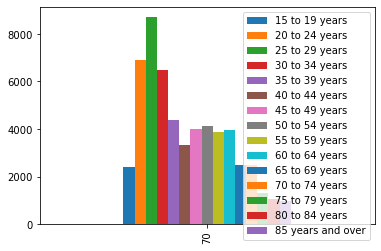

In [44]:
test = df_census_filtered_totals.loc[70:70, '15 to 19 years' : '85 years and over']
test.plot.bar()

In [48]:
test

,17,22,27,32,37,42,47,52,57,62,67,72,77,82,87
70,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0


In [47]:
test = test.rename(columns = {'15 to 19 years' : 17, 
                       '20 to 24 years' : 22, 
                       '25 to 29 years' : 27, 
                       '30 to 34 years' : 32, 
                       '35 to 39 years' : 37,
                       '40 to 44 years' : 42, 
                       '45 to 49 years' : 47, 
                       '50 to 54 years' : 52, 
                       '55 to 59 years' : 57, 
                       '60 to 64 years' : 62, 
                       '65 to 69 years' : 67, 
                       '70 to 74 years' : 72, 
                       '75 to 79 years' : 77, 
                       '80 to 84 years' : 82, 
                       '85 years and over' : 87})

In [98]:
test

,variable,value
0,17,2410.0
1,22,6922.0
2,27,8715.0
3,32,6490.0
4,37,4388.0
5,42,3338.0
6,47,4017.0
7,52,4141.0
8,57,3894.0
9,62,3956.0


In [97]:
test = test.melt(value_vars=test.columns)
#.rename(columns = {0:"hello"})


In [122]:
import altair as alt 

alt.Chart(test).mark_bar(color='red').encode(
    alt.X("hello:Q"),
    alt.Y("value"))

In [80]:
test.insert(2, 'normalized_value', test['value']/7.5)

In [81]:
bar_filled = (alt.Chart(test).mark_area(color='red', interpolate='monotone', fillOpacity=0.2).encode(
    alt.X("variable:Q"),
    alt.Y("normalized_value")))
bar = (alt.Chart(test).mark_bar(color='green').encode(
    alt.X("hello"),
    alt.Y("value")))
alt.layer(chart_test, bar_filled)

alt.LayerChart(...)

In [68]:
alt.Chart(test).transform_density(
    density='value', 
    as_=['hello', 'value']
    ).mark_area(fillOpacity=0.3).encode(
    alt.X('hello:N', axis=alt.Axis(values=list(range(15,85,5)))), 
    alt.Y('value:Q'))

alt.Chart(...)

In [132]:
alt.Chart(test2).transform_density(
    density='value', 
    bandwidth=400,
    as_=['hello', 'value']
    ).mark_area(fillOpacity=0.6).encode(
    alt.X('hello:Q'), 
    alt.Y('value:Q'))

alt.Chart(...)